## Dependencies

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
#import pprint
import sys 
import api_keys
# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

degree_sign= u'\N{DEGREE SIGN}' #used for degree symbol

## Generate Cities List

In [2]:
# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
# Print the city count to confirm sufficient count
print(len(cities))

619


## Create a New Dataframe

In [3]:
#create a df of cities
city_df_blank=pd.DataFrame(cities, columns=['City'])
#city_df.rename(columns={0:'New'})

#add new fields to df
def add_fields(x):
    x['Temperature (F)']=""
    x['Humitidy (%)']=""
    x['Cloudiness (%)']=""
    x['Wind Speed (mph)']=""
    x['Lattitude']=""
    x['Longitude']=""
    x['Distance From Equator']=""

add_fields(city_df_blank)#adds new fields to df

## Perform API Calls

In [4]:
# OpenWeatherMap API Key
api_key = api_keys.api_key
# response = requests.get(url)
# r=response.json()

city_df_raw = city_df_blank

base_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + api_key
missing=0

# Output File (CSV)
output_data_file = "output_data/cities.csv"
# use iterrows to iterate through pandas dataframe
for index, row in city_df_raw.iterrows():
    
    # get restaurant type from df
    city_to_find = row['City']

    # assemble url and make API request
    #print(f"Retrieving Results for Index {index}: {city_to_find}.")
    response = requests.get(base_url+f'&q={city_to_find}').json()

    try:
        #print(response)#(f"Temp is results['main']['temp'] in row['City'].")
        city_df_raw.loc[index,'Temperature (F)'] = float(response['main']['temp'])
        city_df_raw.loc[index,'Lattitude'] = response['coord']['lat']
        city_df_raw.loc[index,'Longitude'] = response['coord']['lon']
        city_df_raw.loc[index,'Humitidy (%)'] = response['main']['humidity']
        city_df_raw.loc[index,'Cloudiness (%)'] = response['clouds']['all']
        city_df_raw.loc[index,'Wind Speed (mph)'] = response['wind']['speed']
        
    except (KeyError, IndexError):
        missing +=1
    #Create Log File
    output=(f"----------------------------------\n" 
            f"Retrieving Results for index: {index} City: {row['City']}.\n"
            f"----------------------------------\n")
    with open('log.txt','a') as txt_file:
        txt_file.write(output)
        #delete "\r" to append instead of overwrite
    sys.stdout.write("\r" + str(index) +' ' + str(row['City'])) #overwrites output cell to avoid a lengthy ouput cell
    sys.stdout.flush()
    #time.sleep(.001)
    
print()
print(f'Missing Cities: {missing}')
print('Starting Cities: ' +str(len(cities)))
print('Final City Count: ' +str(len(cities)-missing)) #final city count; could be used to redo function if <500 cities are found

618 laplace
Missing Cities: 62
Starting Cities: 619
Final City Count: 557


## Clean Up Raw Data in Dataframe

In [5]:
#clean up df created
city_df_clean=city_df_raw

city_df_clean.replace('',np.nan, inplace=True)
city_df_clean['Distance From Equator']=abs(0 - city_df_clean['Lattitude'])

#city_df_clean.head()
city_df_wo_nan=city_df_clean.dropna()
city_df_wo_nan.head()

#Write  new df to csv
city_df_wo_nan.to_csv('cities.csv', index=False)

## Create Figure and Subplots

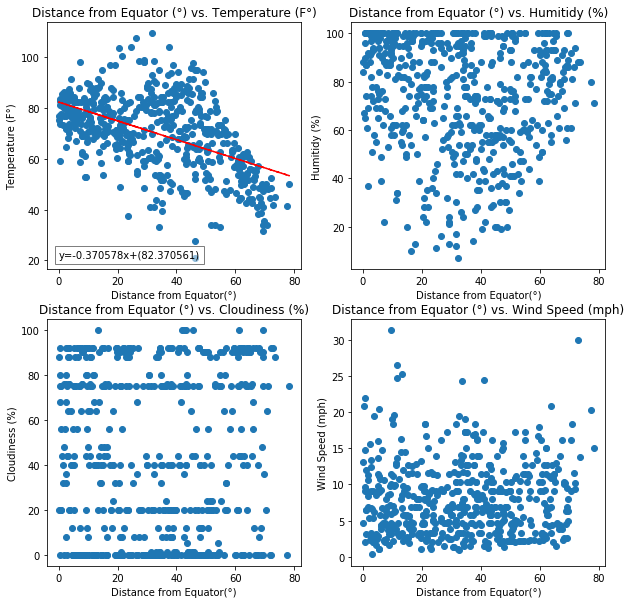

In [7]:
#create a new figure and plot
xax=city_df_wo_nan['Distance From Equator'] #1st subplot axis
yax=city_df_wo_nan['Temperature (F)']

xax2=city_df_wo_nan['Distance From Equator']#2nd subplot axis
yax2=city_df_wo_nan['Humitidy (%)']

xax3=city_df_wo_nan['Distance From Equator']#3rd subplot axis
yax3=city_df_wo_nan['Cloudiness (%)']

xax4=city_df_wo_nan['Distance From Equator']#4th subplot axis
yax4=city_df_wo_nan['Wind Speed (mph)']

# x5=[1,2,3,4,5,6] #used for troubleshooting
# y5=[1,2,3,4,5,6]

fig1 = plt.figure(figsize=(10,10))  # an empty figure with no axes

ax1=fig1.add_subplot(2,2,1) #subplots
ax2=fig1.add_subplot(2,2,2)
ax3=fig1.add_subplot(2,2,3)
ax4=fig1.add_subplot(2,2,4)

#fig1.subplots_adjust(bottom=0) #Cannot get to give space and look good. :-(

ax1.scatter(xax,yax) #create subplot and attributes
# calc the trendline
z = np.polyfit(xax, yax, 1)
p = np.poly1d(z)
ax1.plot(xax,p(xax),"r--")
# the line equation:
equation="y=%.6fx+(%.6f)"%(z[0],z[1])
ax1.title.set_text(f"Distance from Equator ({degree_sign}) vs. Temperature (F{degree_sign})")
ax1.set_ylabel(f'Temperature (F{degree_sign})')
ax1.set_xlabel(f"Distance from Equator({degree_sign})")
ax1.text(0,21,equation,bbox=dict(facecolor='white',alpha=0.5))

ax2.scatter(xax2,yax2)#create subplot and attributes
# calc the trendline
# z2 = np.polyfit(xax2, yax2, 1)
# p2 = np.poly1d(z2)
# ax2.plot(xax2,p2(xax2),"r--")
# the line equation:
#equation="y=%.6fx+(%.6f)"%(z2[0],z2[1])
ax2.title.set_text(f"Distance from Equator ({degree_sign}) vs. Humitidy (%)")
ax2.set_ylabel(f'Humitidy (%)')
ax2.set_xlabel(f"Distance from Equator({degree_sign})")
# ax2.text(-2,33,equation,bbox=dict(facecolor='white',alpha=0.5))

ax3.scatter(xax3,yax3)#create subplot and attributes
#calc the trendline
#z3 = np.polyfit(xax3, yax3, 1)
#p3 = np.poly1d(z3)
# ax3.plot(xax3,p3(xax3),"r--")
#the line equation:
# equation="y=%.6fx+(%.6f)"%(z3[0],z3[1])
ax3.title.set_text(f"Distance from Equator ({degree_sign}) vs. Cloudiness (%)")
ax3.set_ylabel(f'Cloudiness (%)')
ax3.set_xlabel(f"Distance from Equator({degree_sign})")
#ax3.text(-2,33,equation,bbox=dict(facecolor='white',alpha=0.5))

# ax4.scatter(x5,y5) #used for troublshooting trendline

# # calc the trendline
# z4 = np.polyfit(x5, y5, 1)
# p4 = np.poly1d(z4)
# ax4.plot(x5,p4(x5),"r--")
# #the line equation:

# equation="y=%.6fx+(%.6f)"%(z4[0],z4[1])
# ax4.title.set_text(f"Distance from Equator ({degree_sign}) vs. Wind Speed (mph)")
# ax4.set_ylabel(f'Wind Speed (mph)')
# ax4.set_xlabel(f"Distance from Equator({degree_sign})")
# ax4.text(-2,33,equation,bbox=dict(facecolor='white',alpha=0.5))



ax4.scatter(xax4,yax4)

# calc the trendline
# z4 = np.polyfit(xax4, yax4, 1)
# p4 = np.poly1d(z4)
# ax4.plot(xax4,p4(xax4),"r--")
#the line equation:
#equation="y=%.6fx+(%.6f)"%(z4[0],z4[1])
ax4.title.set_text(f"Distance from Equator ({degree_sign}) vs. Wind Speed (mph)")
ax4.set_ylabel(f'Wind Speed (mph)')
ax4.set_xlabel(f"Distance from Equator({degree_sign})")
#ax4.text(-2,0,equation,bbox=dict(facecolor='white',alpha=0.5))

fig1.savefig('scatter_figure1.png') #save figure as png file

## Create Additional Figures of Interest

Text(0.5,0,'Temperature (F°)')

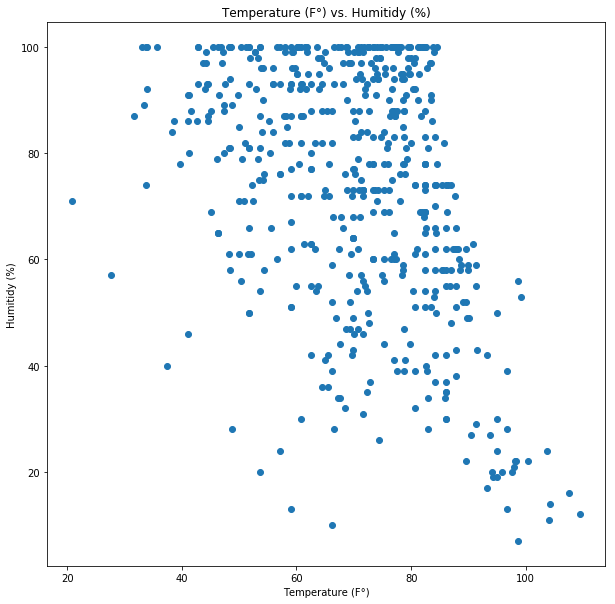

In [8]:
# create a plot of temp vs humidity
xax6=city_df_wo_nan['Temperature (F)']
yax6=city_df_wo_nan['Humitidy (%)']

fig2 = plt.figure(figsize=(10,10))  # an empty figure with no axes
ax6=fig2.add_subplot(1,1,1)

ax6.scatter(xax6,yax6)
#calc the trendline
z6 = np.polyfit(xax6, yax6, 1)
p6 = np.poly1d(z6)
#ax6.plot(xax3,p6(xax6),"r--")
#the line equation:
#equation="y=%.6fx+(%.6f)"%(z6[0],z6[1])
ax6.title.set_text(f"Temperature (F{degree_sign}) vs. Humitidy (%)")
ax6.set_ylabel(f'Humitidy (%)')
ax6.set_xlabel(f"Temperature (F{degree_sign})")
#ax6.text(-2,33,equation,bbox=dict(facecolor='white',alpha=0.5))


## Three Observations
### Observation 1:
There is a clear trend in distance from equator and temperature.  The further away from the equator the lower the observed temperature.  The temperatures oberseved for a given distance fromm equator varied widely. This suggests that other factors contribute to temperature.  Other factors may include, elevation, surrounding terrain and effects of wind or sea currents. 
### Observation 2:
Cloudiness scatter points appear in distinct bands.  Many of the bands are multiples of 10.  This suggests that the mechanism for reporting cloudiness involves binning or reporting in multiples of 10. Another possible explanantion is that when humans are asked to estimate a percentage, we often give values in multiples of 10 or 5.  If human observation is involved this could explain the banding pattern. 
### Observation 3:
There appears to be a distinct limit of humididty.  As distance from equator increases the minimum observed humidity level increases.  This also appears to be an exponential limit and not a linear one.  In an effor to explore this relationship further a Temperature vs. Humidity plot was created. The plot shows a tornado or cone shape that suggests an upper and lower limit to humidity that changes with temperature.  
### Observation 4:
There appears to be no correlation between wind speed and distance from equator.  Each lattitude had similar patterns of wind speed with a clustering towards lower wind speeds. 